<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Plot-final-gate-obtained-via-training" data-toc-modified-id="Plot-final-gate-obtained-via-training-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Plot final gate obtained via training</a></span></li><li><span><a href="#Optimisation-code-used-to-obtain-the-gate" data-toc-modified-id="Optimisation-code-used-to-obtain-the-gate-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Optimisation code used to obtain the gate</a></span></li><li><span><a href="#Parameter-plots" data-toc-modified-id="Parameter-plots-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parameter plots</a></span></li><li><span><a href="#Fidelities-vs-parameters" data-toc-modified-id="Fidelities-vs-parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fidelities vs parameters</a></span><ul class="toc-item"><li><span><a href="#Fidelity-vs-time" data-toc-modified-id="Fidelity-vs-time-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Fidelity vs time</a></span></li><li><span><a href="#Vary-single-parameters" data-toc-modified-id="Vary-single-parameters-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Vary single parameters</a></span></li></ul></li></ul></div>

In [92]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import glob
from IPython.display import display
from IPython.core.debugger import set_trace
from collections import OrderedDict
import itertools
import os
import sys
import pickle
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sympy
import pandas as pd

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

import cufflinks

import qutip
import theano
import theano.tensor as T

src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

import qubit_network.net_analysis_tools as nat
import qubit_network.utils
from qubit_network.utils import chop, complex2bigreal, bigreal2complex, bigreal2qobj
from qubit_network.QubitNetwork import pauli_product
from qubit_network.model import QubitNetworkGateModel
from qubit_network.Optimizer import Optimizer
from qubit_network.net_analysis_tools import NetDataFile, NetsDataFolder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# in `nets` are saved the nets obtained using the old interface
# (in particular, the optimisation histories were not saved)
toffredkin_datafile = NetsDataFolder('../data/nets').filter('toffredkin*')[0]
display(toffredkin_datafile.fidelity_test(n_samples=1000))
# the data in `new_nets` was obtained running the optimisation from the net saved in `nets`
toffredkin_datafile = NetsDataFolder('../data/new_nets').filter('toffredkin*')[0]
toffredkin_datafile.fidelity_test(n_samples=1000)

0.9999909262903446

1.000000019614055

In [96]:
net, _ = nat.load_network_from_file('../data/new_nets/toffredkin_all.pickle')
fids = net.fidelity_test(n_samples=10000, return_mean=False)
# std_deviation = np.sqrt(np.sum((fids - fids.mean())**2) / (fids.shape[0] - 1))
pd.Series(fids).describe()

count    1.000000e+04
mean     1.000000e+00
std      1.082383e-08
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64

# Plot final gate obtained via training

<IPython.core.display.Javascript object>


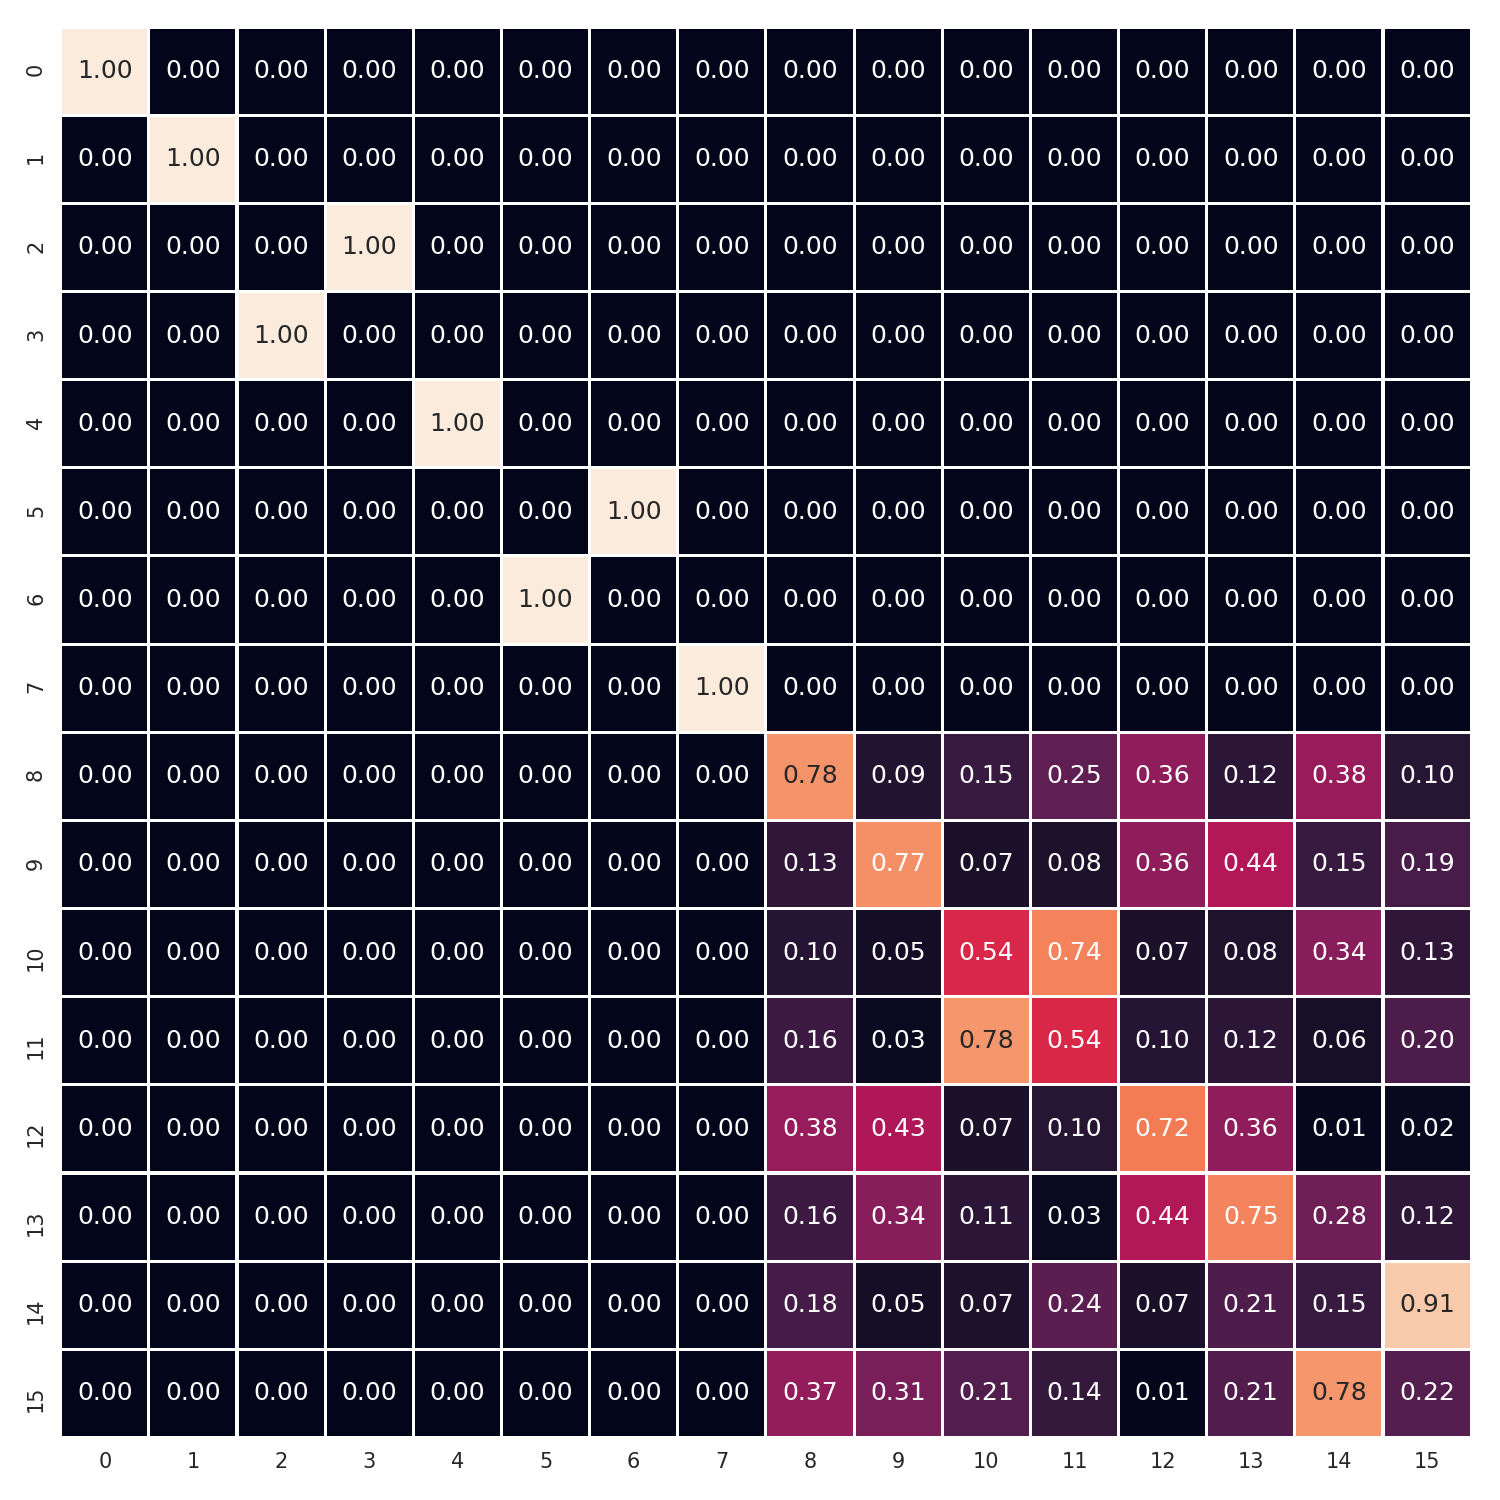

In [6]:
toffredkin_datafile = NetsDataFolder('../data/new_nets').filter('toffredkin*')[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nat.plot_gate(toffredkin_datafile, permutation=[3, 0, 1, 2], ax=ax)
plt.tight_layout()
# fig.savefig('toffredkin_finalmatrix.pdf')

# Optimisation code used to obtain the gate

Compiling model ... done.


<IPython.core.display.Javascript object>


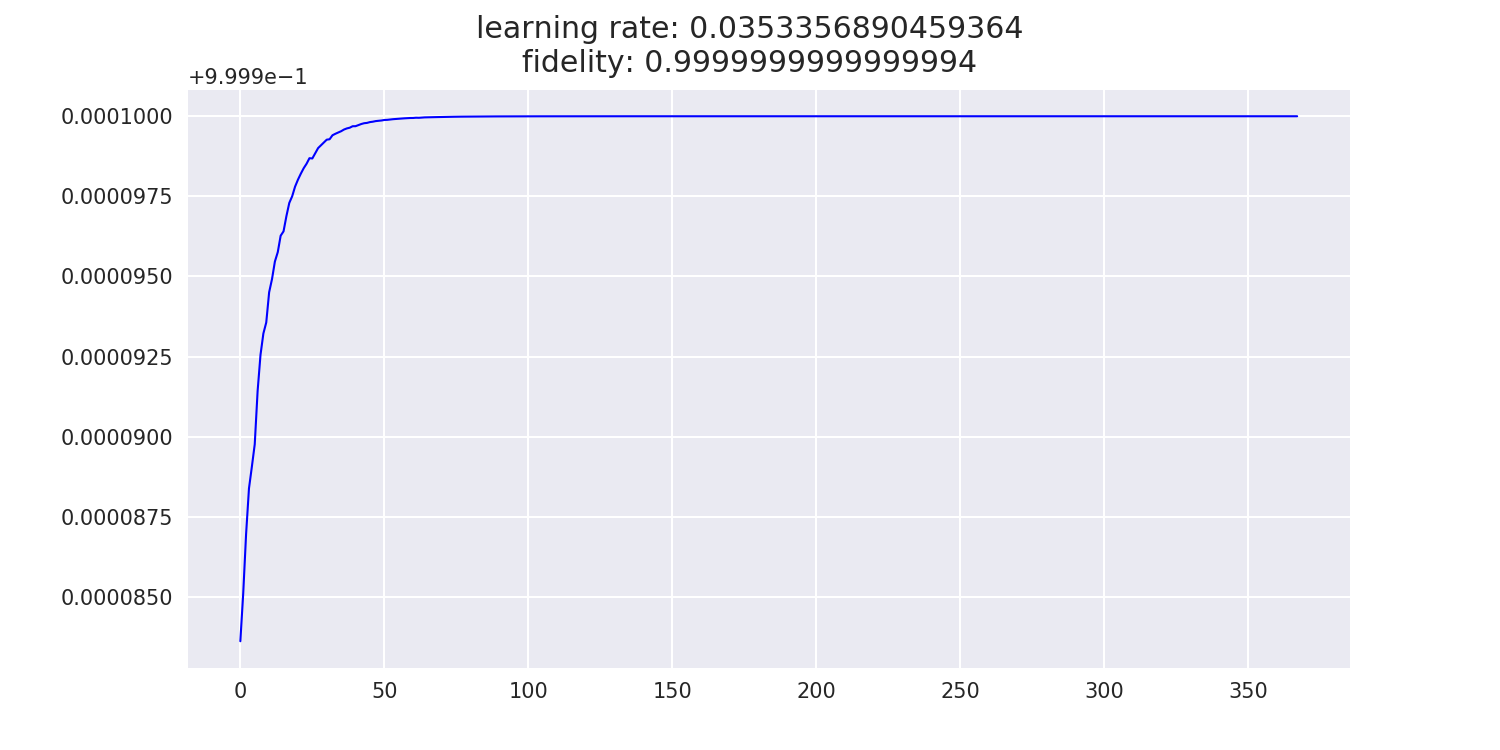

In [52]:
# build toffredkin gate
toffredkin = qutip.tensor(qutip.projection(2, 0, 0), qutip.cnot())
toffredkin += qutip.tensor(qutip.projection(2, 1, 1), qutip.swap())
toffredkin
# uncomment following line to start training from pretrained net
# toffredkin_datafile = NetsDataFolder('../data/nets').filter('toffredkin*')[0]

# setup and start optimisation
optimizer = Optimizer(
    net=toffredkin_datafile.data,
    learning_rate=.1,
    decay_rate=.005,
    n_epochs=400,
    batch_size=2,
    target_gate=toffredkin,
    training_dataset_size=200,
    test_dataset_size=100,
    sgd_method='momentum'
)
optimizer.run()

In [53]:
optimizer.save_results('../data/new_nets/toffredkin_all.pickle')

Successfully saved to ../data/new_nets/toffredkin_all.pickle


# Parameter plots

In [41]:
NetsDataFolder('../data/new_nets').filter('toffredkin*').plot_parameters()

The optimisation for the final saved gate was started from an already quite well-trained gate, hence why the training history of the parameters seems to be almost flat

In [42]:
Optimizer.load('../data/new_nets/toffredkin_all.pickle').plot_parameters_history()

The following cell produces the plot used in the paper:

<IPython.core.display.Javascript object>


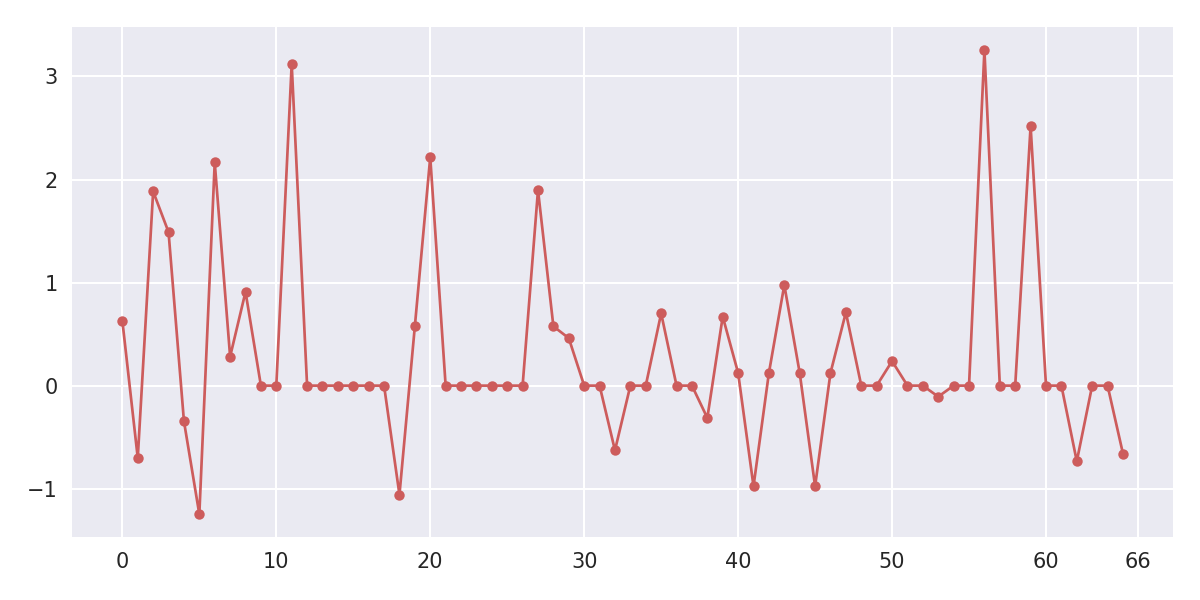

In [49]:
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

data = NetsDataFolder('../data/new_nets/').filter('toffredkin*').view_parameters().values[:, 0]
# df.T.reset_index(drop=True).plot(ax=ax, marker='o', markersize=4., legend=False)
ax.plot(np.arange(data.shape[0]), data, 'o-', color='indianred', markersize=5, linewidth=1.3)

# ax.set_title('Different solutions for Toffoli with diagonal interactions', fontsize=16)
# ax.set_xlabel('Parameters', fontsize=14)
# ax.set_xlabel('')
# ax.set_ylabel('Values', fontsize=14)

# better range
# ax.set_xlim(-0.1 , 8.1)
# mathify xaxis labels
ax.set_xticks(np.concatenate([np.arange(0, data.shape[0], 10), [66]]))
# fix sizes
plt.tight_layout()
# save to file
# fig.savefig('toffredkin_all.pdf', bbox_inches='tight')

# Fidelities vs parameters

## Fidelity vs time

<IPython.core.display.Javascript object>


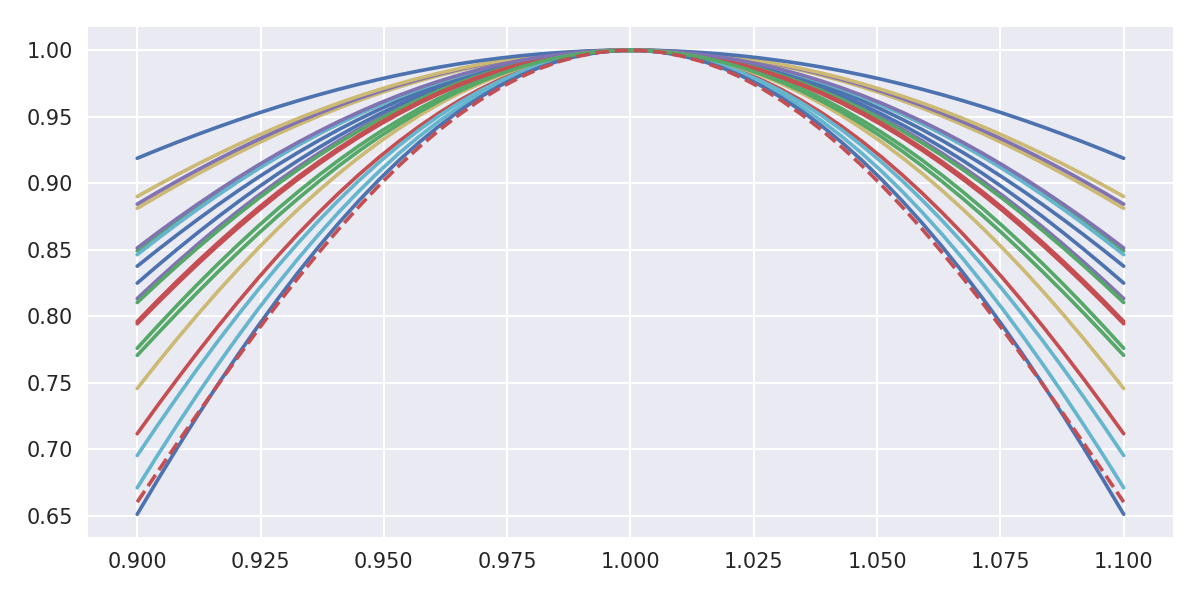

100% (50 of 50) |#########################| Elapsed Time: 0:00:17 Time: 0:00:17


In [79]:
net, _ = nat.load_network_from_file('../data/new_nets/toffredkin_all.pickle')
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
nat.plot_fidelity_vs_J_qutip(net, xs=np.linspace(0.9, 1.1, 50), index_to_vary='all', n_states=20, ax=ax)
plt.tight_layout()
# fig.savefig('toffredkin_fidVStime.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


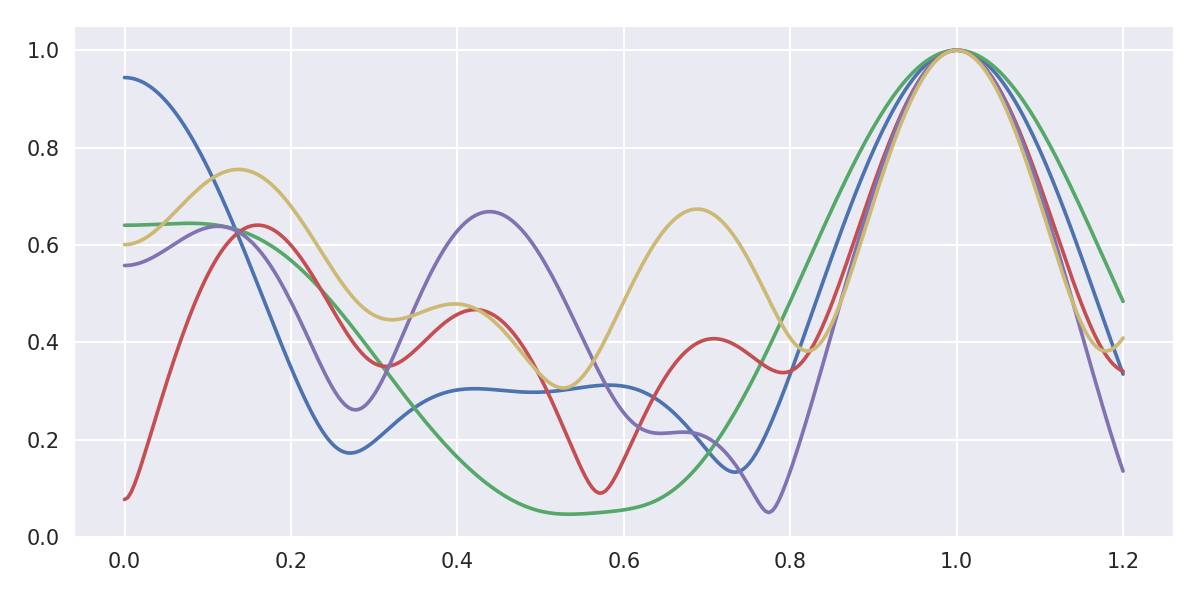

100% (300 of 300) |#######################| Elapsed Time: 0:01:43 Time: 0:01:43


In [90]:
net, _ = nat.load_network_from_file('../data/new_nets/toffredkin_all.pickle')
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
nat.plot_fidelity_vs_J_qutip(net, xs=np.linspace(0, 1.2, 300), index_to_vary='all', n_states=5, ax=ax)
plt.tight_layout()
# fig.savefig('toffredkin_fidVStime_wide.pdf', bbox_inches='tight')

## Vary single parameters

<IPython.core.display.Javascript object>


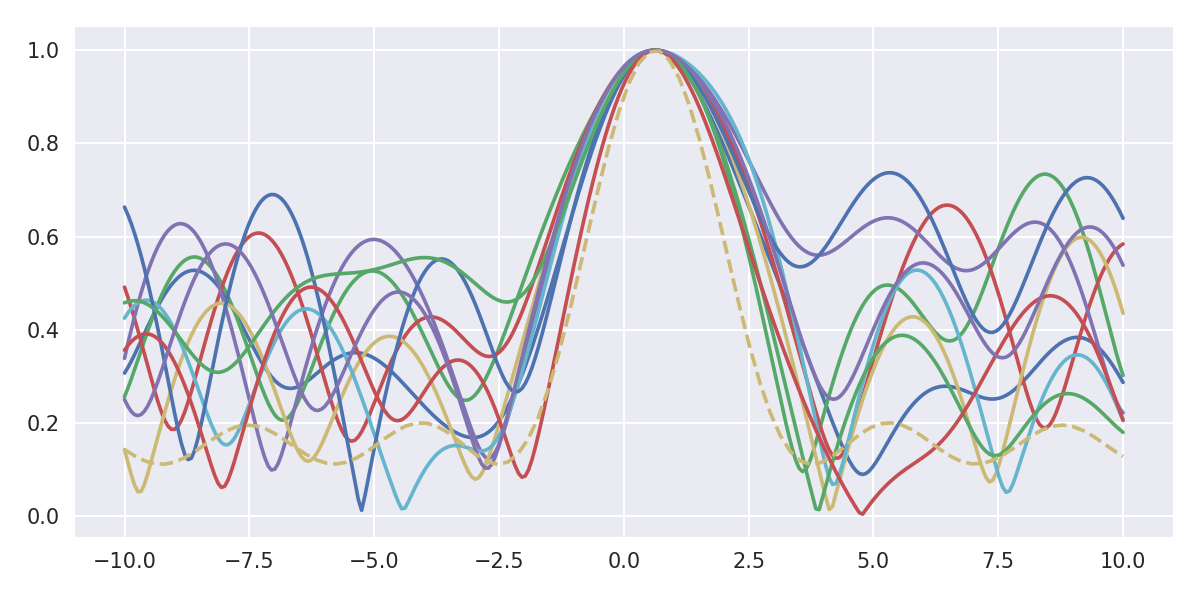

100% (300 of 300) |#######################| Elapsed Time: 0:01:41 Time: 0:01:41


In [81]:
net, _ = nat.load_network_from_file('../data/new_nets/toffredkin_all.pickle')
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
nat.plot_fidelity_vs_J_qutip(net, xs=np.linspace(-10, 10, 300), index_to_vary=0, n_states=10, ax=ax)
plt.tight_layout()

<IPython.core.display.Javascript object>


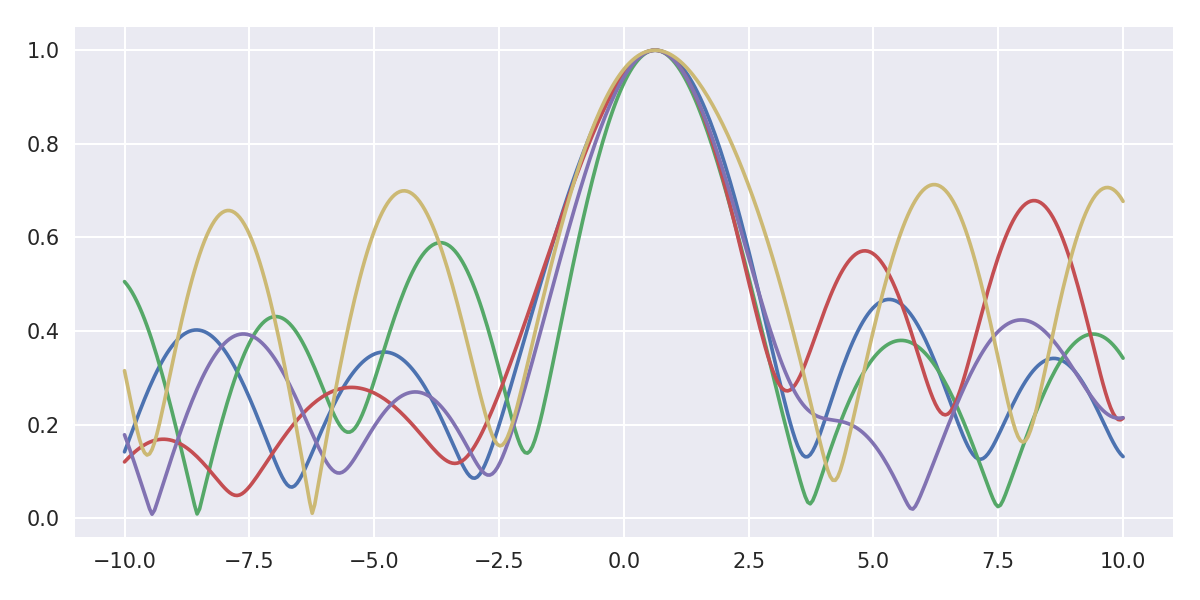

100% (400 of 400) |#######################| Elapsed Time: 0:02:15 Time: 0:02:15


In [86]:
net, _ = nat.load_network_from_file('../data/new_nets/toffredkin_all.pickle')
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
nat.plot_fidelity_vs_J_qutip(net, xs=np.linspace(-10, 10, 400), index_to_vary=0, n_states=5, ax=ax)
plt.tight_layout()
# fig.savefig('toffredkin_fidVSpar0.pdf')

<IPython.core.display.Javascript object>


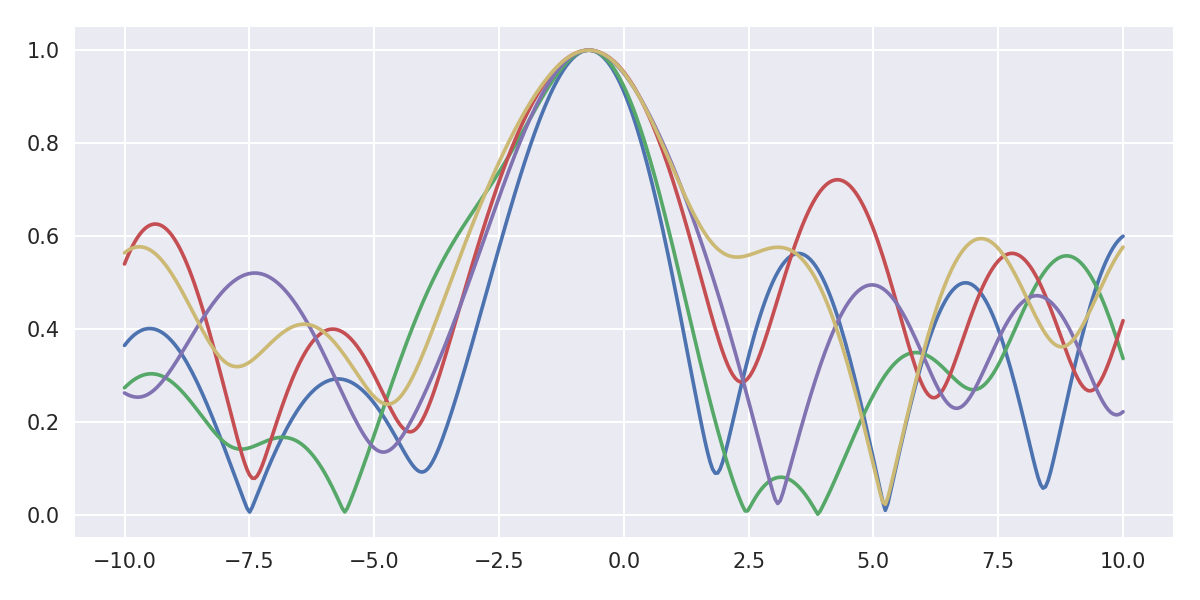

100% (400 of 400) |#######################| Elapsed Time: 0:02:14 Time: 0:02:14


In [88]:
net, _ = nat.load_network_from_file('../data/new_nets/toffredkin_all.pickle')
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
nat.plot_fidelity_vs_J_qutip(net, xs=np.linspace(-10, 10, 400), index_to_vary=1, n_states=5, ax=ax)
plt.tight_layout()
# fig.savefig('toffredkin_fidVSpar1.pdf')